In [1]:
pwd

'/home/vmu/nu_stats'

In [2]:
%cd examples/bayes_hierarchical_model/

/home/vmu/nu_stats/examples/bayes_hierarchical_model


In [3]:
%load_ext autoreload
%autoreload 2

# SIM

In [4]:
from astropy import units as u
import numpy as np
from cmdstanpy import CmdStanModel
import arviz, corner
from matplotlib import pyplot as plt

In [5]:
import sys
sys.path.append("../../")
from nu_stats.simulation import Simulation
from nu_stats.plotting import unit_vectors_skymap as u_v_s

In [6]:
# Simulation parameters
L = 1e48 * (u.erg/u.s)
gamma = 2.2
z = 0.3
atm_flux_norm = 1e-15 * 1/(u.GeV * u.cm**2 * u.s)
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [7]:
sim = Simulation(L, gamma, z,
    atm_flux_norm = atm_flux_norm,
    Emin=Emin, Emax=Emax, Enorm=Enorm)
sim.run(seed=40)


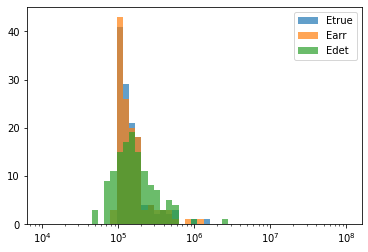

In [8]:
sim.show_spectrum()

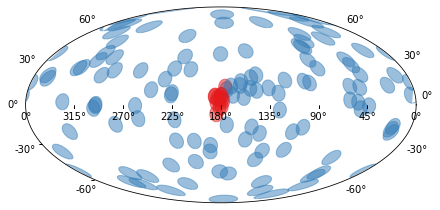

In [9]:
sim.show_skymap()

In [10]:
sim.truth

OrderedDict([('L', 6.2415090744607645e+50),
             ('gamma', 2.2),
             ('F_bg', 3.7037036742841397e-07),
             ('f', 0.11504009222207819)])

In [11]:
(sim.labels == 0).sum()

13

In [12]:
sim.Nex_ps

15.193779688702278

In [13]:
# Extract simulated data and get info needed for fit
fit_input = sim.get_data()

In [14]:
#fit_input

# FQTIST FIT

In [15]:
from nu_stats.fqutils import FqStructure, plot_loghist

In [16]:
# With energy part
fq = FqStructure()
fq.construct_atm_bg_energy_likelihood(
    Emin, Emax, n_Esim=100000,
    Nbins=50, prefab_likelihood_file='tmp/atmospheric_50lik.npy'
    )
fq.construct_source_energy_likelihood(
    fit_input['z'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
    Nbins=25, prefab_likelihood_file='tmp/True0.3_25lik.npy'
)

Generating atmospheric background energy likelihood..
Separate marginalized energy likelihood generated for bg.
Generating marginalized energy likelihood..
Marginalized energy likelihood generated.


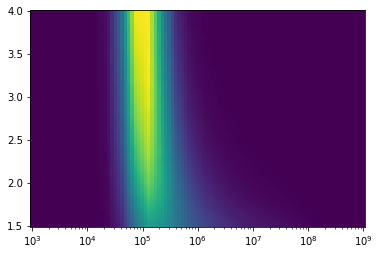

In [17]:
fq.energy_likelihood.plot_pdf_meshgrid();

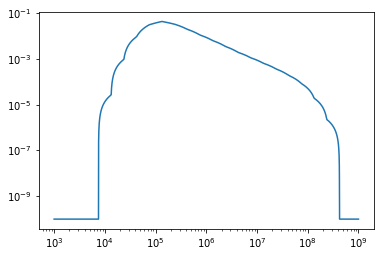

In [18]:
fq.energy_likelihood.plot_pdf_at_idx(2)
plt.yscale('log')

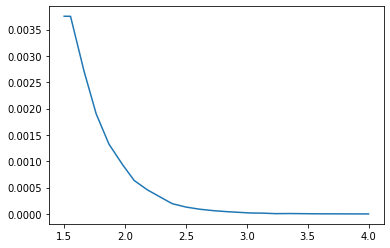

In [19]:
fq.energy_likelihood.plot_pdf_at_E(1e7);

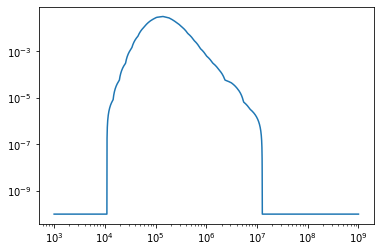

In [20]:
fq.bg_energy_likelihood.plot_pdf()
plt.yscale('log')

The log(full fit input likelihood) for a pair n_s, gamma can be evaluated as follows:

In [21]:
n_s_eg = 3
gamma_eg = 2
fq.fit_input = fit_input
fq.log_band_likelihood(n_s_eg, gamma_eg)

-803.0456486070167

Above can be evaluated for arrays of different n_s and gamma as follows:

In [22]:
n_ss = np.arange(fit_input['N'])
gammas = np.linspace(1.6,4,100) 
glbl = fq.grid_log_band_likelihood(n_ss, gammas) # *

# result is saved in the fq object as well
assert (glbl == fq.lbl_grid).all() 

n_h, g_h = fq.argmax_band_likelihood()
# no args: grid kept from *


In [23]:
n_h

14

In [24]:
g_h

1.9636363636363638

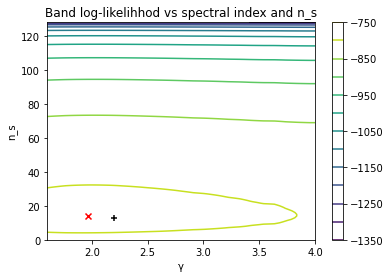

In [25]:
fq.plot_lbl_contour()
plt.scatter(sim.truth['gamma'], sum(sim.labels==0), marker='+', c ='k')
# plt.ylim(3,20)
plt.show()


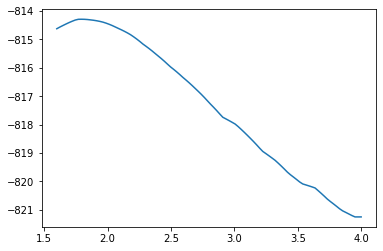

In [26]:
plt.plot(gammas, fq.lbl_grid[1,:]); # log_likelihood for 15th event

In [27]:
m, mn_h, mg_h = fq.minimize_neg_lbl()


In [28]:
m.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 792.6                      │              Nfcn = 186              │
│ EDM = 7.67e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_s   │   14.4    │    3.7    │    -3.4    │    4.0     │    0    │   128   │       │
│ 1 │ gamma │   1.97    │   0.09    │   -0.27    │    0.32    │   1.5   │    4    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          n_s          │         gamma         │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -3.4    │    4.0    │   -0.27   │   0.32    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────┐
│       │     n_s   gamma │
├───────┼─────────────────┤
│   n_s │    13.7 0.00385 │
│ gamma │ 0.00385 0.00902 │
└───────┴─────────────────┘

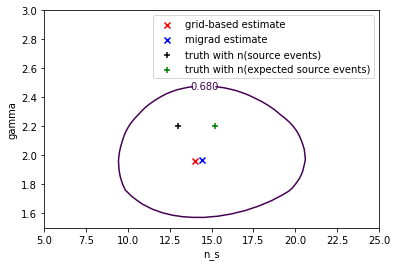

In [29]:
m.draw_mncontour('n_s','gamma')
plt.scatter(n_h, g_h, marker='x', c ='r')
plt.scatter(mn_h, mg_h, marker='x', c ='b')
plt.scatter(sum(sim.labels==0),sim.truth['gamma'], marker='+', c ='k')
plt.scatter(sim.Nex_ps, sim.truth['gamma'], marker='+', c ='g')
plt.legend(['grid-based estimate', 'migrad estimate', 'truth with n(source events)','truth with n(expected source events)'])
plt.xlim((5,25))
plt.ylim((1.5,3.0))
plt.show()

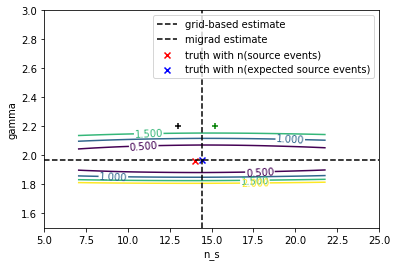

In [30]:
m.draw_contour('n_s','gamma')
plt.scatter(n_h, g_h, marker='x', c ='r')
plt.scatter(mn_h, mg_h, marker='x', c ='b')
plt.scatter(sum(sim.labels==0),sim.truth['gamma'], marker='+', c ='k')
plt.scatter(sim.Nex_ps, sim.truth['gamma'], marker='+', c ='g')
plt.legend(['grid-based estimate', 'migrad estimate', 'truth with n(source events)','truth with n(expected source events)'])
plt.xlim((5,25))
plt.ylim((1.5,3.0))
plt.show()

The source likelihood for a specific event for different gammas can be evaluated as follows:

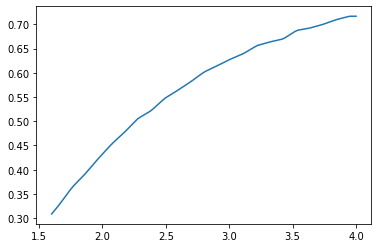

In [31]:
fq.event_source_likelihood_from_index(gammas, 30)
plt.plot(gammas, fq.sl_arr)
plt.show()

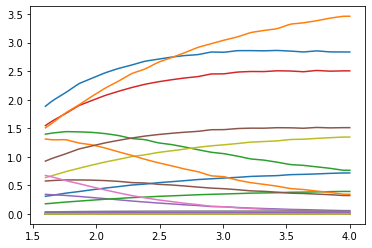

In [32]:
for event_i in range(fit_input['N']):
    plt.plot(gammas,
         fq.event_source_likelihood_from_index(gammas, event_i))
plt.show()

## FqStructure can also be set to ignore energy part:

In [33]:
fq_noE = FqStructure() # Only spatial

In [34]:
#fq_noE.log_band_likelihood(fit_input, 39,2)

In [35]:
glbl = fq_noE.grid_log_band_likelihood(np.arange(fit_input['N']),  np.linspace(1.5,4), fit_input=fit_input)

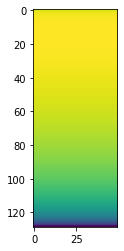

In [36]:
plt.imshow(glbl)

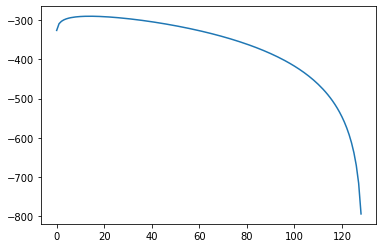

In [37]:
plt.plot(glbl[:,1]);

In [38]:
m = fq_noE.minimize_neg_lbl()[0]

In [39]:
m.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 290.4                      │              Nfcn = 23               │
│ EDM = 1.23e-07 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_s   │   13.9    │    3.7    │    -3.4    │    4.0     │    0    │   128   │       │
│ 1 │ gamma │    0.0    │    0.1    │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │          n_s          │
├──────────┼───────────┬───────────┤
│  Error   │   -3.4    │    4.0    │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌───────┬─────────────┐
│       │   n_s gamma │
├───────┼─────────────┤
│   n_s │  13.6     0 │
│ gamma │     0     0 │
└───────┴─────────────┘

## Individual associations

In [40]:
bg_sim = Simulation(atm_flux_norm=atm_flux_norm, Emin=Emin, Emax=Emax, Enorm=Enorm, N_events=100000)
bg_sim.run(seed=12345678)
bg_dat = bg_sim.get_data()

In [41]:
bg_sim.truth

OrderedDict([('L', 0.0),
             ('gamma', 2.0),
             ('F_bg', 3.7037036742841397e-07),
             ('f', 0.0)])

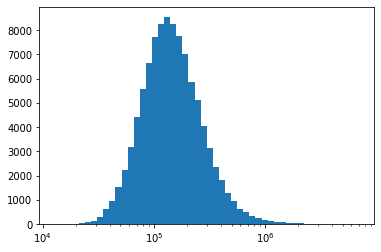

In [42]:
plot_loghist(bg_dat['Edet'],50);

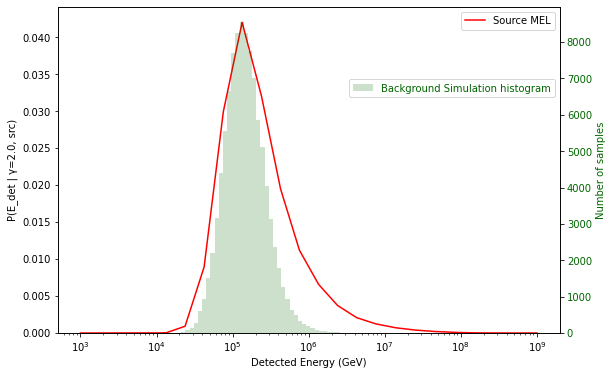

In [69]:
fig, ax = plt.subplots()

fq.energy_likelihood.plot_pdf_at_idx(g_h, color = 'r')
plt.legend(['Source MEL'], loc='upper right')
ax.set_xlabel('Detected Energy (GeV)')
ax.set_ylabel(f'P(E_det | γ={g_h:.2}, src)')
ax.set_ylim(0,(ax.get_ylim()[1]))

axh = ax.twinx()

plot_loghist(bg_dat['Edet'],50,color=(0,0.4,0,0.2))
sim_col = (0,0.4,0)
plt.legend(['Background Simulation histogram'],
    loc = 'center right',
    bbox_to_anchor = (0.5, 0.5, 0.5, 0.5),
    labelcolor = sim_col
)
axh.set_ylabel('Number of samples', color=sim_col)
axh.tick_params(axis='y', labelcolor=sim_col)

fig.set_size_inches(*(fig.get_size_inches()*1.5))
fig.show()



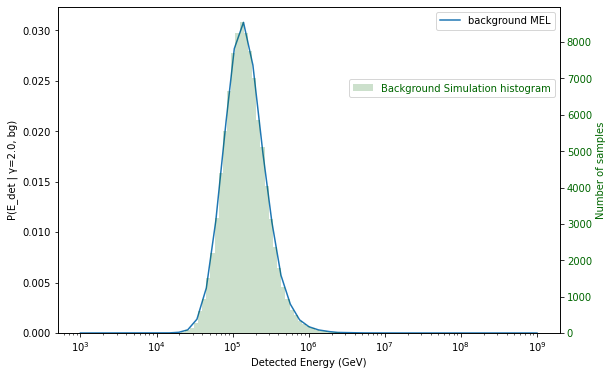

In [44]:
fig, ax = plt.subplots()

fq.bg_energy_likelihood.plot_pdf()
plt.legend(['background MEL'], loc='upper right')
ax.set_xlabel('Detected Energy (GeV)')
ax.set_ylabel(f'P(E_det | γ={g_h:.2}, bg)')
ax.set_ylim(0,(ax.get_ylim()[1]))

axh = ax.twinx()

plot_loghist(bg_dat['Edet'],50,color=(0,0.4,0,0.2))
sim_col = (0,0.4,0)
plt.legend(['Background Simulation histogram'],
    loc = 'center right',
    bbox_to_anchor = (0.5, 0.5, 0.5, 0.5),
    labelcolor = sim_col
)
axh.set_ylabel('Number of samples', color=sim_col)
axh.tick_params(axis='y', labelcolor=sim_col)

fig.set_size_inches(*(fig.get_size_inches()*1.5))
fig.show()

In [45]:
ll = [fq.energy_likelihood(energ, g_h) for energ in bg_dat['Edet']]

In [46]:
## get p values
sim_TS, bg_TS, sim_p = fq.event_statistics(fit_input, bg_dat, g_h)
## set label 0 for p<.01 and 1 for p>=.01
labels = (sim_p >=.01).astype(int)

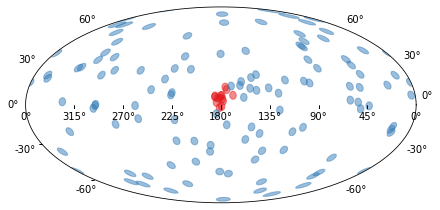

In [47]:
u_v_s(fit_input['det_dir'], labels);

In [48]:
np.mean(labels == sim.labels)

0.9767441860465116

In [49]:
print(f'Source event fraction\nfit: {np.mean(1-labels)}\n\
true: {np.mean(1-sim.labels)}\n\n\
False source events: {np.inner(1-sim.labels, labels)}\n\
False bg events: {np.inner(1-labels, sim.labels)}')

Source event fraction
fit: 0.10852713178294573
true: 0.10077519379844961

False source events: 1
False bg events: 2


In [50]:
bg_TS.sort()

In [51]:
frac = lambda x: np.mean(bg_TS > x)
y = np.array([frac(elem) for elem in bg_TS])

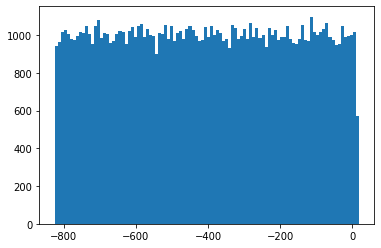

In [52]:
plt.hist(bg_TS,bins=100);

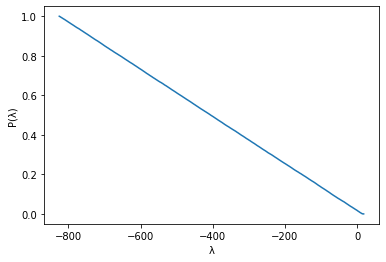

In [53]:

plt.step(bg_TS, y);
plt.xlabel('λ');
plt.ylabel('P(λ)');
#plt.yscale('log');

# BHM

In [54]:
from nu_stats.bhmutils import BhStructure

In [55]:
bhm = BhStructure(fit_input)
bhm.load_model("stan/bhm_atm.stan")

INFO:cmdstanpy:compiling stan program, exe file: /home/vmu/nu_stats/examples/bayes_hierarchical_model/stan/bhm_atm
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/home/vmu/nu_stats/examples/bayes_hierarchical_model/stan']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/bayes_hierarchical_model/stan/bhm_atm


In [56]:
bhm.run()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


In [57]:
bhm.print_diagnostic()

INFO:cmdstanpy:Processing csv files: /tmp/tmpcihu_40p/bhm_atm-202104121812-1-a_p5wg7h.csv, /tmp/tmpcihu_40p/bhm_atm-202104121812-2-4ox5b31b.csv, /tmp/tmpcihu_40p/bhm_atm-202104121812-3-p_v74zk3.csv, /tmp/tmpcihu_40p/bhm_atm-202104121812-4-1a43tp58.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


In [58]:
bhm.vars.keys()

dict_keys(['gamma', 'L', 'F_bg', 'Etrue', 'f', 'F_src', 'F', 'Nex', 'Nex_ps', 'Nex_bg', 'log_prob', 'Earr'])

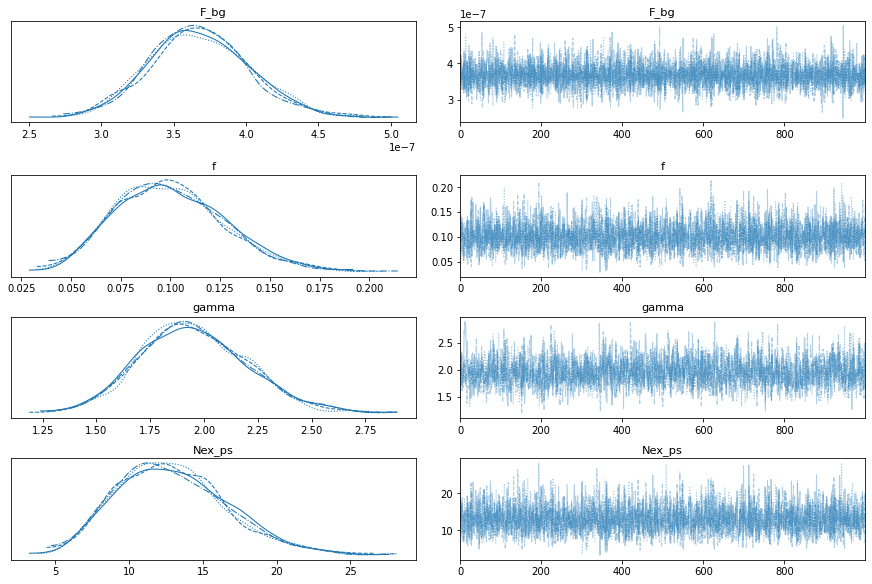

In [59]:
# Trace plot
var_names = ["F_bg", "f", "gamma", "Nex_ps"]
bhm.plot_traces(var_names)


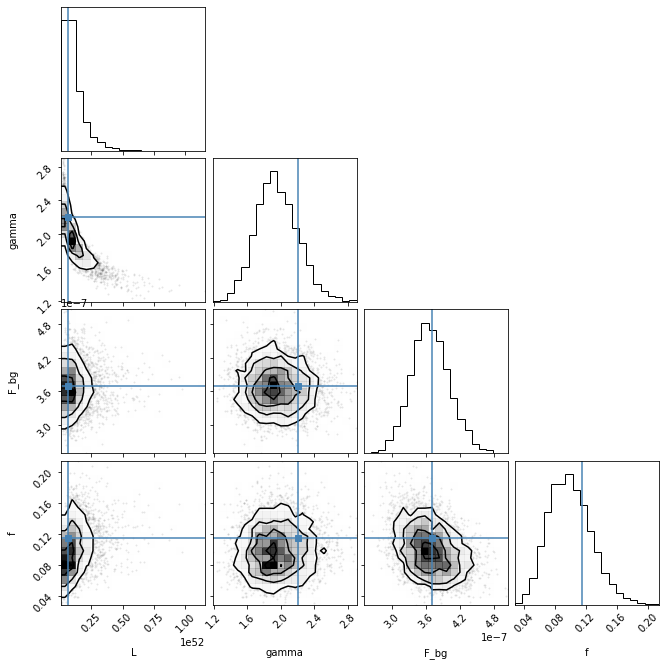

In [60]:
# Corner plot, comparing with truth from sim
var_names = list(sim.truth.keys())
truths_list = [sim.truth[key] for key in var_names]
bhm.plot_corner(var_names, truths_list)

In [61]:
bhm.print_summary()

                   Mean          MCSE        StdDev            5%  \
name                                                                
lp__      -4.200000e+03  2.600000e-01  9.400000e+00 -4.200000e+03   
gamma      2.000000e+00  5.200000e-03  2.500000e-01  1.600000e+00   
L          1.200000e+51  2.100000e+49  9.900000e+50  3.300000e+50   
F_bg       3.700000e-07  4.400000e-10  3.400000e-08  3.100000e-07   
Etrue[1]   1.411460e+05  5.810000e+02  4.328300e+04  1.020240e+05   
...                 ...           ...           ...           ...   
Earr[125]  1.340410e+05  4.740000e+02  3.675900e+04  1.015280e+05   
Earr[126]  2.785590e+05  1.911000e+03  1.481060e+05  1.208660e+05   
Earr[127]  1.667060e+05  8.500000e+02  6.794400e+04  1.041950e+05   
Earr[128]  1.432080e+05  6.170000e+02  4.463200e+04  1.023000e+05   
Earr[129]  2.127520e+05  1.169000e+03  9.780200e+04  1.082590e+05   

                    50%           95%   N_Eff  N_Eff/s  R_hat  
name                                  

## Individual associations


In [62]:
association = bhm.classify_events()

In [63]:
labels_b = (association[:,0] <.01).astype(int)

In [64]:
labels_b

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [65]:
labels_b.mean()

0.875968992248062

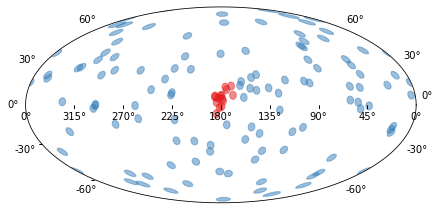

In [66]:
u_v_s(fit_input['det_dir'], labels_b);

In [67]:
np.mean(labels_b == sim.labels)

0.9767441860465116

In [68]:
print(f'Source event fraction\nfit: {np.mean(1-labels_b)}\n\
true: {np.mean(1-sim.labels)}\n\n\
False source events: {np.inner(sim.labels, 1-labels_b)}\n\
False bg events: {np.inner(labels_b, 1-sim.labels)}')

Source event fraction
fit: 0.12403100775193798
true: 0.10077519379844961

False source events: 3
False bg events: 0
